# Classifying the Iris Dataset with Einets

This tutorial demonstrates how to classify the Iris dataset using Einets, which are a type of probabilistic model well-suited for tasks like classification. We'll go through setting up the environment, preparing the data, building the model, training it, and finally visualizing the decision boundary.

## Environment Setup

First, we need to import the necessary libraries. Make sure to install these using `pip` or `conda` before starting.


In [19]:
import torch
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from simple_einet.einet import Einet, EinetConfig
from simple_einet.layers.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

The Iris dataset can be loaded directly from scikit-learn, and we will use PyTorch for handling the data.


In [20]:
# Load the Iris dataset
iris = datasets.load_iris()
# Reduce the dataset to 2 dimensions for visualization purposes
iris.data = iris.data[:, [0, 1]]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).long()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).long()


## Model Configuration

Here, we set up the Einet model configuration using the predefined structure and parameters.


In [56]:
# Define model configuration using default values
config = EinetConfig(
    num_features=2,
    depth=1,
    num_sums=5,
    num_leaves=5,
    num_repetitions=5,
    num_classes=3,
    leaf_type=Normal,
    leaf_kwargs={},
    dropout=0.0,
)

# Initialize the model
model = Einet(config)


Number of parameters: 222


## Training the Model

The training process involves defining an optimizer, loss function, and iterating over the training data for a number of epochs.


In [57]:
# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
cross_entropy = torch.nn.CrossEntropyLoss()

# Define a function to compute accuracy
def accuracy(model, X, y):
    with torch.no_grad():
        outputs = model(X)
        predictions = outputs.argmax(-1)
        correct = (predictions == y).sum()
        total = y.shape[0]
        return correct / total * 100

# Training loop
for epoch in range(50):
    optimizer.zero_grad()
    log_likelihoods = model(X_train)
    loss = cross_entropy(log_likelihoods, y_train)
    loss.backward()
    optimizer.step()

    acc_train = accuracy(model, X_train, y_train)
    acc_test = accuracy(model, X_test, y_test)
    print(f"Epoch: {epoch + 1}, Loss: {loss.item():.2f}, Accuracy Train: {acc_train:.2f} %, Accuracy Test: {acc_test:.2f} %")


Epoch: 1, Loss: 1.06, Accuracy Train: 69.00 %, Accuracy Test: 68.00 %
Epoch: 2, Loss: 0.98, Accuracy Train: 75.00 %, Accuracy Test: 76.00 %
Epoch: 3, Loss: 0.91, Accuracy Train: 78.00 %, Accuracy Test: 74.00 %
Epoch: 4, Loss: 0.84, Accuracy Train: 81.00 %, Accuracy Test: 74.00 %
Epoch: 5, Loss: 0.77, Accuracy Train: 75.00 %, Accuracy Test: 70.00 %
Epoch: 6, Loss: 0.71, Accuracy Train: 73.00 %, Accuracy Test: 72.00 %
Epoch: 7, Loss: 0.65, Accuracy Train: 77.00 %, Accuracy Test: 70.00 %
Epoch: 8, Loss: 0.61, Accuracy Train: 77.00 %, Accuracy Test: 74.00 %
Epoch: 9, Loss: 0.57, Accuracy Train: 73.00 %, Accuracy Test: 74.00 %
Epoch: 10, Loss: 0.55, Accuracy Train: 80.00 %, Accuracy Test: 72.00 %
Epoch: 11, Loss: 0.52, Accuracy Train: 75.00 %, Accuracy Test: 72.00 %
Epoch: 12, Loss: 0.50, Accuracy Train: 73.00 %, Accuracy Test: 76.00 %
Epoch: 13, Loss: 0.49, Accuracy Train: 81.00 %, Accuracy Test: 72.00 %
Epoch: 14, Loss: 0.48, Accuracy Train: 75.00 %, Accuracy Test: 72.00 %
Epoch: 15, Loss

## Visualizing the Decision Boundary

Finally, let's visualize the decision boundary of our trained model along with the test data points.


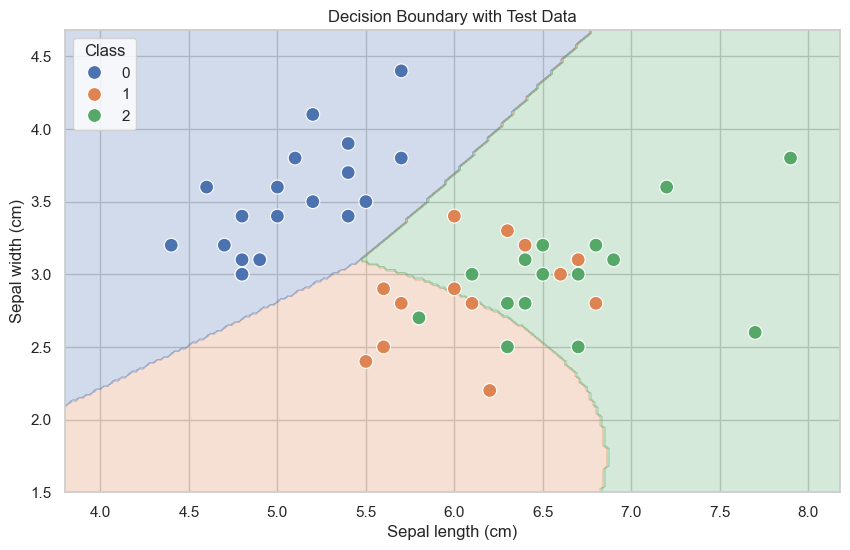

In [58]:
# Set seaborn style for plotting
sns.set(style="whitegrid")

# Create a meshgrid for the contour plot
x_0_min, x_0_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x_1_min, x_1_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx_0, xx_1 = np.meshgrid(np.arange(x_0_min, x_0_max, 0.1), np.arange(x_1_min, x_1_max, 0.1))

# Evaluate the model on the grid to get the decision boundary
mesh_input = torch.tensor(np.c_[xx_0.ravel(), xx_1.ravel()]).float()
with torch.no_grad():
    mesh_output = model(mesh_input)
    mesh_classes = mesh_output.argmax(-1).view(xx_0.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
cmap = sns.color_palette("deep", 3)
cmap = ListedColormap(cmap.as_hex())
plt.contourf(xx_0, xx_1, mesh_classes.numpy(), alpha=0.25, cmap=cmap)

# Overlay the test data points
sns.scatterplot(x=X_test[:, 0].numpy(), y=X_test[:, 1].numpy(), hue=y_test.numpy(), palette=cmap, edgecolor="w", s=100)

# Add plot title and labels
plt.title("Decision Boundary with Test Data")
plt.xlabel(iris.feature_names[0].capitalize())
plt.ylabel(iris.feature_names[1].capitalize())
plt.legend(loc="upper left", title="Class")
plt.show()
